<a href="https://colab.research.google.com/github/rafavidal1709/projeto_aplicado_iv/blob/main/PAIV_Visualiza%C3%A7%C3%A3o_e_Predi%C3%A7%C3%A3o_com_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 43.9 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import numpy as np
from datetime import datetime, timedelta
import rasterio
import matplotlib.pyplot as plt
import json
import tqdm

# Listar imagens limpas

In [5]:
base_path = "/content/drive/MyDrive/copernicus_s2_sr_harmonized/"

all_files = os.listdir(base_path)

padrao = re.compile(r'(\d{4}_\d{2}_\d{2})\_clean.tif$', re.IGNORECASE)
dates = sorted(set(match.group(1) for nome in all_files if (match := padrao.match(nome))))

print(len(dates))

padrao = re.compile(r'(\d{4}_\d{2}_\d{2})\_note.npy$', re.IGNORECASE)
notes = sorted(set(match.group(1) for nome in all_files if (match := padrao.match(nome))))

len(notes)

313


42

In [ ]:
def mostrar_rgb_normalizado(path_tif):
    with rasterio.open(path_tif) as src:
        img = src.read()  # Shape: (C, H, W)

    # Usa os canais 1, 2, 3 (índices 1, 2, 3) como B, G, R
    bgr = img[1:4]  # shape: (3, H, W)

    # Normaliza valores de 0 a 2000 para 0 a 255
    bgr = np.clip(bgr, 0, 2000)
    bgr = (bgr / 2000.0 * 255).astype(np.uint8)

    # Transpõe para (H, W, 3)
    rgb_img = np.transpose(bgr[::-1], (1, 2, 0))  # inverte BGR → RGB

    # Mostra a imagem
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.title("Imagem Normalizada (RGB)")
    plt.show()

mostrar_rgb_normalizado(base_path+dates[-1]+"_clean.tif")

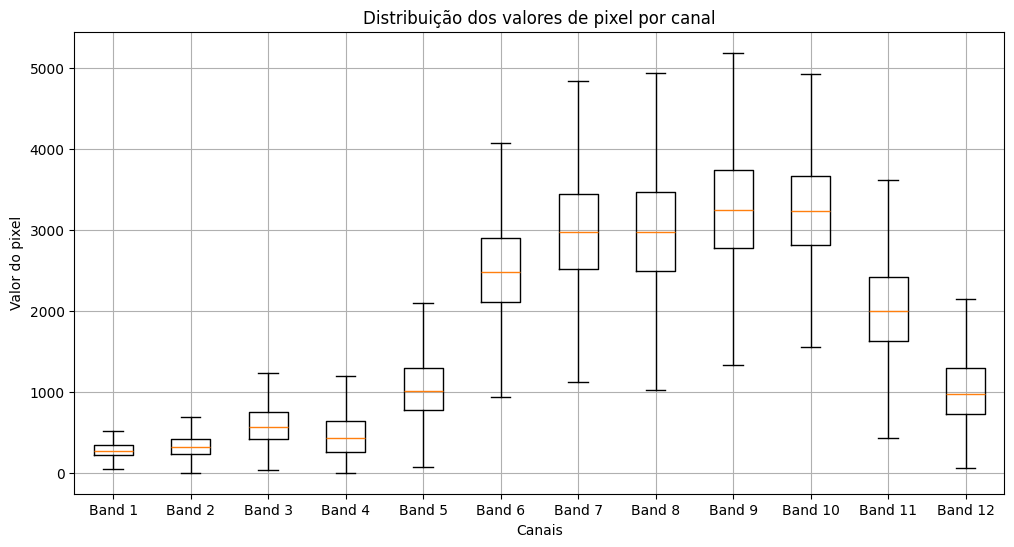

In [ ]:
def boxplot_canais(path_tif):
    with rasterio.open(path_tif) as src:
        img = src.read()  # Shape: (C, H, W)
        num_canais = img.shape[0]

    # Achata os valores de cada canal
    canais_flat = [img[i].flatten() for i in range(num_canais)]

    # Plota boxplot
    plt.figure(figsize=(12, 6))
    plt.boxplot(canais_flat, tick_labels=[f'Band {i+1}' for i in range(num_canais)], showfliers=False)
    plt.title("Distribuição dos valores de pixel por canal")
    plt.xlabel("Canais")
    plt.ylabel("Valor do pixel")
    plt.grid(True)
    plt.show()

boxplot_canais(base_path+dates[-1]+"_clean.tif")

In [8]:
def estatisticas_canais(path_tif):
    with rasterio.open(path_tif) as src:
        img = src.read()  # Shape: (C, H, W)
        num_canais = img.shape[0]

    estatisticas = []
    for i in range(num_canais):
        dados = img[i].flatten()

        canal_stats = {
            'banda': f'Band {i+1}',
            'media': float(np.mean(dados)),
            'mediana': float(np.median(dados)),
            'q1': float(np.percentile(dados, 25)),
            'q3': float(np.percentile(dados, 75)),
            'min': float(np.min(dados)),
            'max': float(np.max(dados)),
            'desvio_padrao': float(np.std(dados))
        }

        estatisticas.append(canal_stats)

    return estatisticas

estatisticas_canais(base_path+dates[-2]+"_clean.tif")

[{'banda': 'Band 1',
  'media': 249.28690974495683,
  'mediana': 218.0,
  'q1': 173.0,
  'q3': 275.0,
  'min': 9.0,
  'max': 12643.0,
  'desvio_padrao': 164.70338081996834},
 {'banda': 'Band 2',
  'media': 347.53462052683835,
  'mediana': 309.0,
  'q1': 224.0,
  'q3': 398.0,
  'min': 0.0,
  'max': 12176.0,
  'desvio_padrao': 227.65066094382695},
 {'banda': 'Band 3',
  'media': 596.2837358782971,
  'mediana': 546.0,
  'q1': 405.0,
  'q3': 714.0,
  'min': 44.0,
  'max': 10128.0,
  'desvio_padrao': 293.0877329759246},
 {'banda': 'Band 4',
  'media': 509.7366577645228,
  'mediana': 411.0,
  'q1': 247.0,
  'q3': 608.0,
  'min': 0.0,
  'max': 9672.0,
  'desvio_padrao': 407.07052298271543},
 {'banda': 'Band 5',
  'media': 1048.2146559758298,
  'mediana': 974.0,
  'q1': 746.0,
  'q3': 1246.0,
  'min': 74.0,
  'max': 10515.0,
  'desvio_padrao': 422.34855137504053},
 {'banda': 'Band 6',
  'media': 2441.145447729462,
  'mediana': 2402.0,
  'q1': 2073.0,
  'q3': 2790.0,
  'min': 45.0,
  'max': 982

In [9]:
try:
  with open(base_path + "dados.json", "r") as f:
      dados = json.load(f)
except:
  dados = {}

for date in tqdm.tqdm(dates):
    if not date in dados: # and date not in notes:
        dados[date] = estatisticas_canais(base_path+date+"_clean.tif")

print(len(dados))

100%|██████████| 313/313 [04:38<00:00,  1.12it/s]

313


In [10]:
with open(base_path + "dados.json", "w") as f:
    json.dump(dados, f, indent=2)

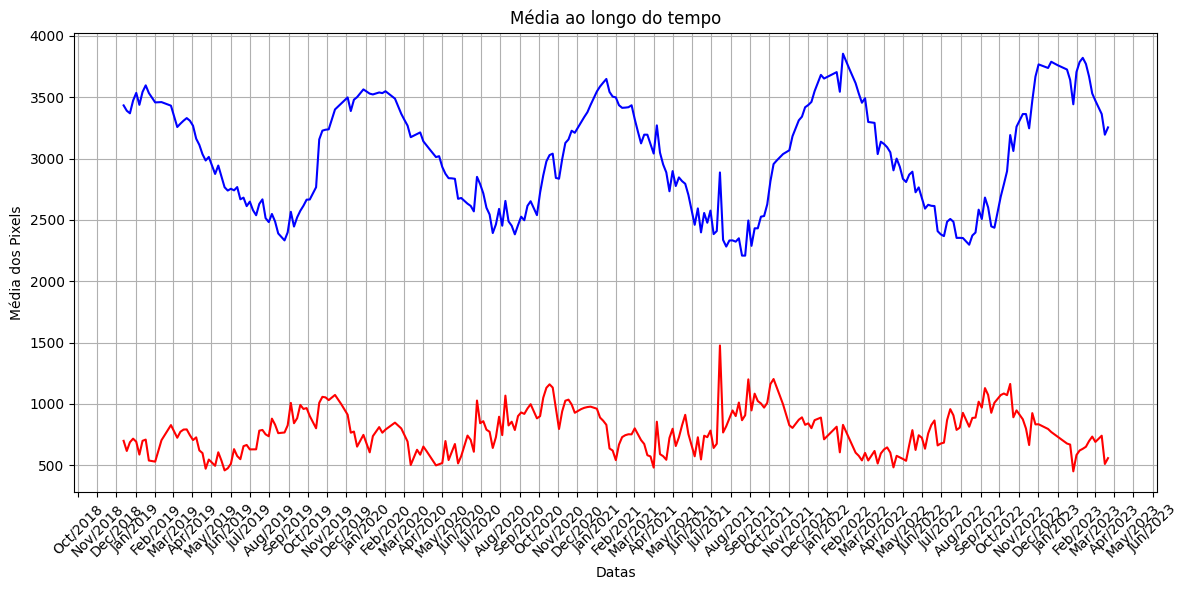

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_media_canal(dados):
    # Converte as datas para objetos datetime
    datas = sorted(dados.keys())
    datas_dt = [datetime.strptime(date, "%Y_%m_%d") for date in datas]
    medias_red = [dados[date][3]["media"] for date in datas]
    medias_water = [dados[date][8]["media"] for date in datas]

    plt.figure(figsize=(12, 6))
    plt.plot(datas_dt, medias_red, color="red")
    plt.plot(datas_dt, medias_water, color="blue")
    plt.title(f"Média ao longo do tempo")
    plt.xlabel("Datas")
    plt.ylabel("Média dos Pixels")

    # Formatação do eixo X: um tick por mês
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
    plt.xticks(rotation=45)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_media_canal(dados)

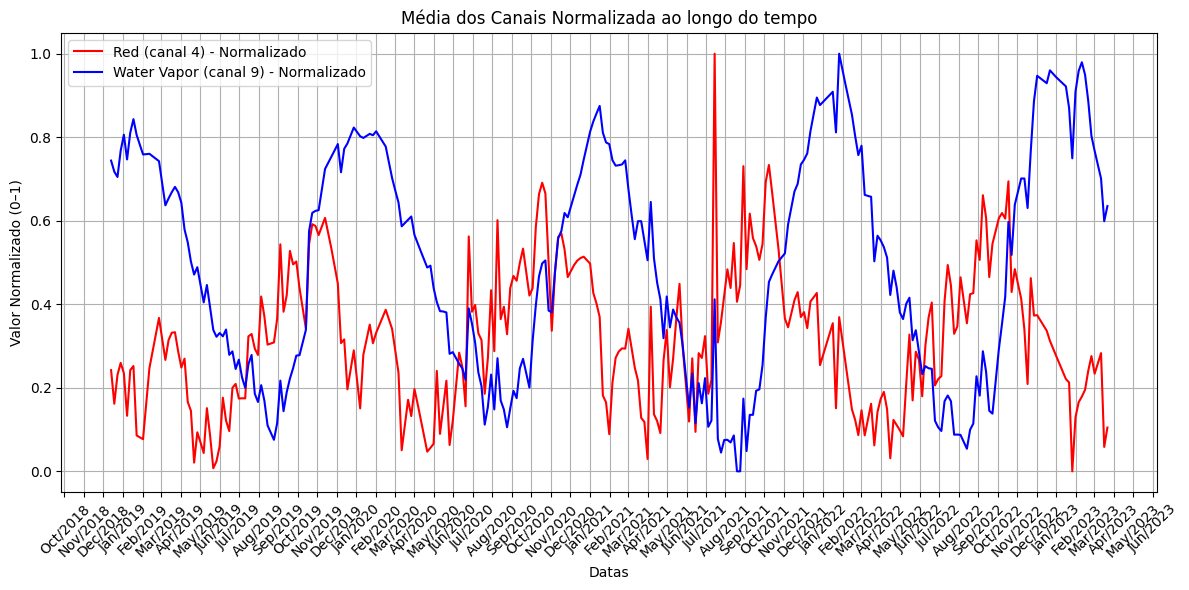

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def min_max_scale(valores):
    minimo = min(valores)
    maximo = max(valores)
    return [(v - minimo) / (maximo - minimo) if maximo != minimo else 0 for v in valores]

def plot_media_canal(dados):
    datas = sorted(dados.keys())
    datas_dt = [datetime.strptime(date, "%Y_%m_%d") for date in datas]

    medias_red = [dados[date][3]["media"] for date in datas]
    medias_water = [dados[date][8]["media"] for date in datas]

    # Aplicar Min-Max Scaling
    red_scaled = min_max_scale(medias_red)
    water_scaled = min_max_scale(medias_water)

    plt.figure(figsize=(12, 6))
    plt.plot(datas_dt, red_scaled, color="red", label="Red (canal 4) - Normalizado")
    plt.plot(datas_dt, water_scaled, color="blue", label="Water Vapor (canal 9) - Normalizado")

    plt.title("Média dos Canais Normalizada ao longo do tempo")
    plt.xlabel("Datas")
    plt.ylabel("Valor Normalizado (0–1)")
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_media_canal(dados)


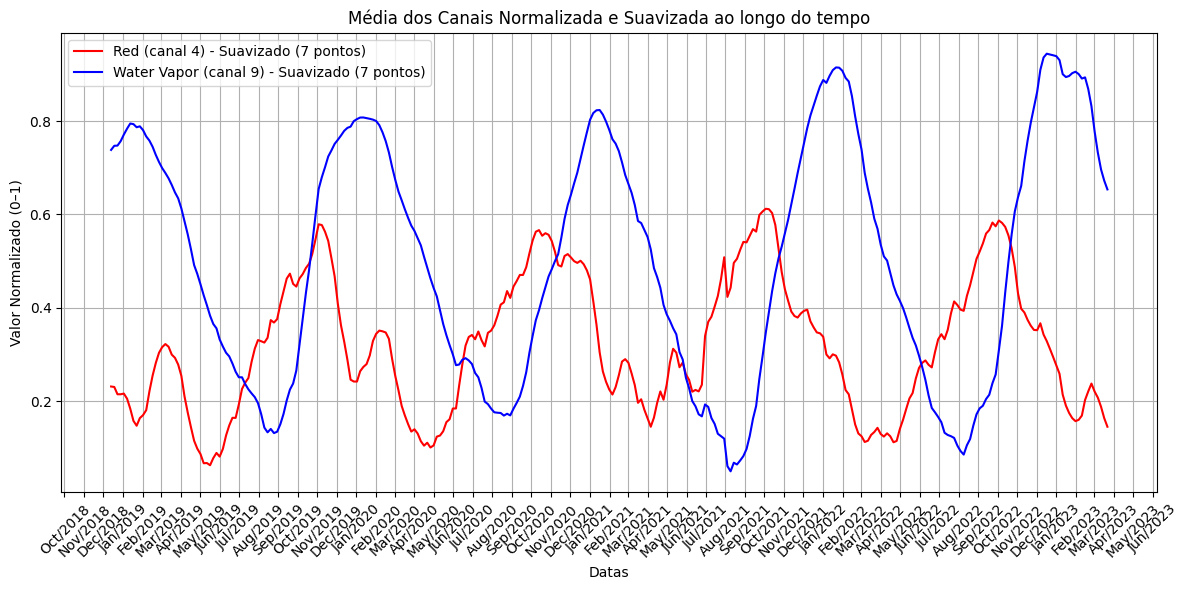

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def min_max_scale(valores):
    minimo = min(valores)
    maximo = max(valores)
    return [(v - minimo) / (maximo - minimo) if maximo != minimo else 0 for v in valores]

def moving_average(valores, window_size=5):
    if window_size <= 1:
        return valores
    padding = window_size // 2
    valores_padded = [valores[0]] * padding + valores + [valores[-1]] * padding
    suavizado = [
        sum(valores_padded[i:i+window_size]) / window_size
        for i in range(len(valores))
    ]
    return suavizado

def plot_media_canal(dados, window_size=5):
    datas = sorted(dados.keys())
    datas_dt = [datetime.strptime(date, "%Y_%m_%d") for date in datas]

    medias_red = [dados[date][3]["media"] for date in datas]
    medias_water = [dados[date][8]["media"] for date in datas]

    # Aplicar Min-Max Scaling
    red_scaled = min_max_scale(medias_red)
    water_scaled = min_max_scale(medias_water)

    # Aplicar média móvel
    red_smooth = moving_average(red_scaled, window_size)
    water_smooth = moving_average(water_scaled, window_size)

    plt.figure(figsize=(12, 6))
    plt.plot(datas_dt, red_smooth, color="red", label=f"Red (canal 4) - Suavizado ({window_size} pontos)")
    plt.plot(datas_dt, water_smooth, color="blue", label=f"Water Vapor (canal 9) - Suavizado ({window_size} pontos)")

    plt.title("Média dos Canais Normalizada e Suavizada ao longo do tempo")
    plt.xlabel("Datas")
    plt.ylabel("Valor Normalizado (0–1)")
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Exemplo de uso:
plot_media_canal(dados, window_size=7)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


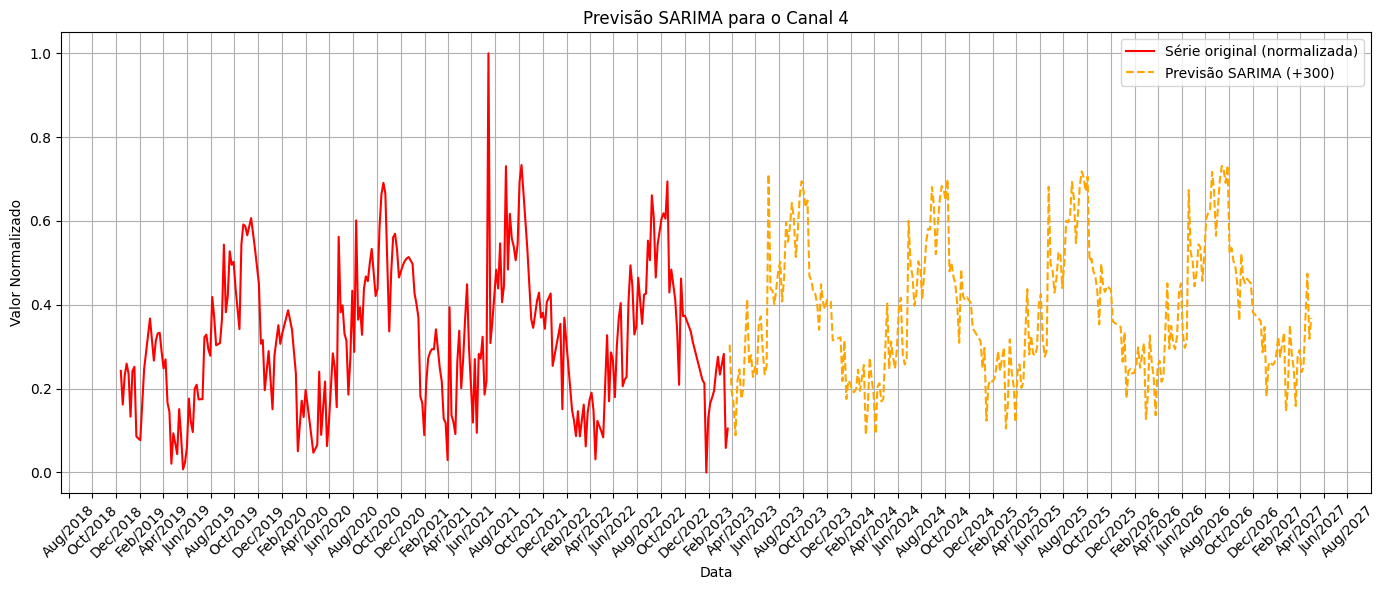

In [14]:
def plot_sarima_forecast(dados, canal_index=3, sazonalidade=72, steps_a_frente=30):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from datetime import datetime, timedelta
    import numpy as np

    datas = sorted(dados.keys())
    datas_dt = [datetime.strptime(date, "%Y_%m_%d") for date in datas]
    serie = [dados[date][canal_index]["media"] for date in datas]

    # Normaliza
    minimo, maximo = min(serie), max(serie)
    serie_norm = [(v - minimo) / (maximo - minimo) for v in serie]

    modelo = SARIMAX(
        serie_norm,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, sazonalidade),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    resultado = modelo.fit(disp=False)
    previsao = resultado.forecast(steps=steps_a_frente)

    intervalo = datas_dt[1] - datas_dt[0]
    datas_futuras = [datas_dt[-1] + (i + 1) * intervalo for i in range(steps_a_frente)]

    # Plotagem
    plt.figure(figsize=(14, 6))
    plt.plot(datas_dt, serie_norm, label="Série original (normalizada)", color='red')
    plt.plot(datas_futuras, previsao, label=f"Previsão SARIMA (+{steps_a_frente})", linestyle="--", color='orange')

    plt.title("Previsão SARIMA para o Canal {}".format(canal_index + 1))
    plt.xlabel("Data")
    plt.ylabel("Valor Normalizado")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_sarima_forecast(dados, canal_index=3, sazonalidade=72, steps_a_frente=300)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


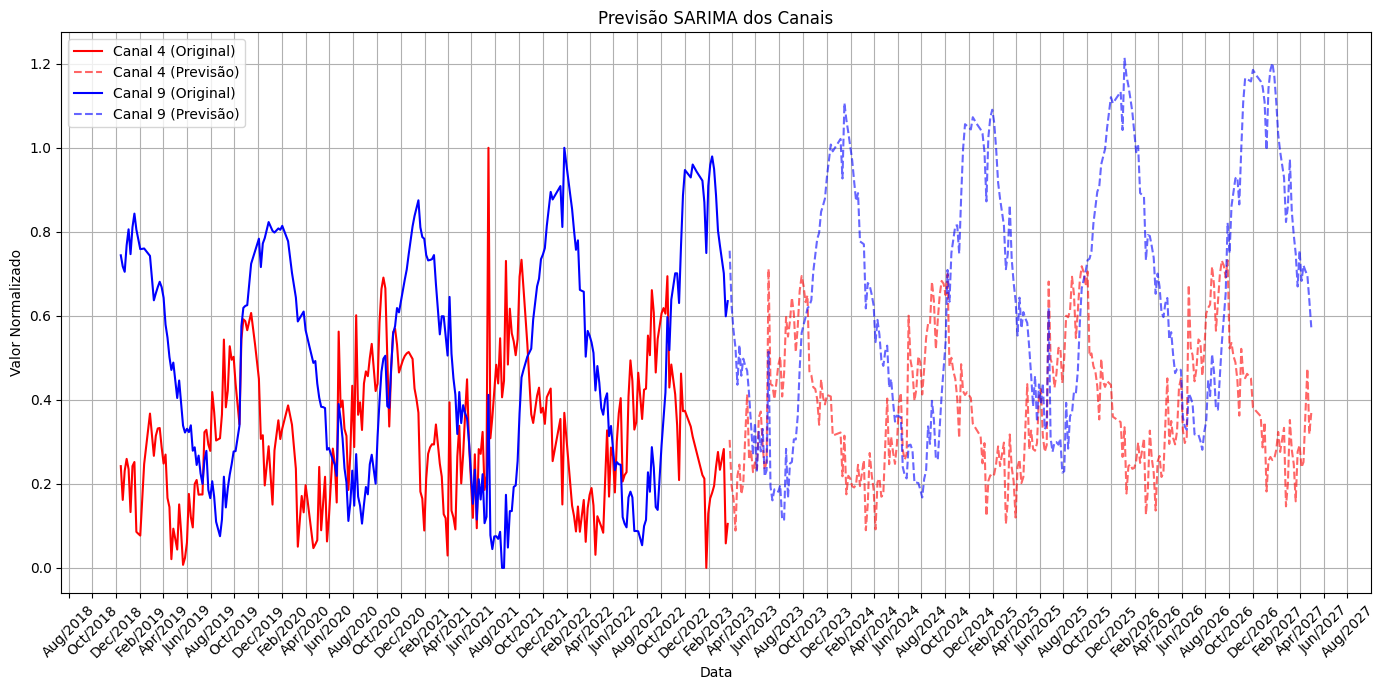

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

def plot_sarima_forecast_duplo(dados, canais=(3, 8), sazonalidade=72, steps_a_frente=300):
    datas = sorted(dados.keys())
    datas_dt = [datetime.strptime(date, "%Y_%m_%d") for date in datas]

    intervalo = datas_dt[1] - datas_dt[0]
    datas_futuras = [datas_dt[-1] + (i + 1) * intervalo for i in range(steps_a_frente)]

    plt.figure(figsize=(14, 7))

    for canal_index, cor in zip(canais, ['red', 'blue']):
        serie = [dados[date][canal_index]["media"] for date in datas]

        # Normaliza
        minimo, maximo = min(serie), max(serie)
        serie_norm = [(v - minimo) / (maximo - minimo) for v in serie]

        # Modelo SARIMA
        modelo = SARIMAX(
            serie_norm,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, sazonalidade),
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        resultado = modelo.fit(disp=False)
        previsao = resultado.forecast(steps=steps_a_frente)

        # Plotar original + previsão
        plt.plot(datas_dt, serie_norm, label=f"Canal {canal_index + 1} (Original)", color=cor)
        plt.plot(datas_futuras, previsao, '--', label=f"Canal {canal_index + 1} (Previsão)", color=cor, alpha=0.6)

    plt.title("Previsão SARIMA dos Canais")
    plt.xlabel("Data")
    plt.ylabel("Valor Normalizado")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Chamada:
plot_sarima_forecast_duplo(dados, canais=(3, 8), sazonalidade=72, steps_a_frente=300)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


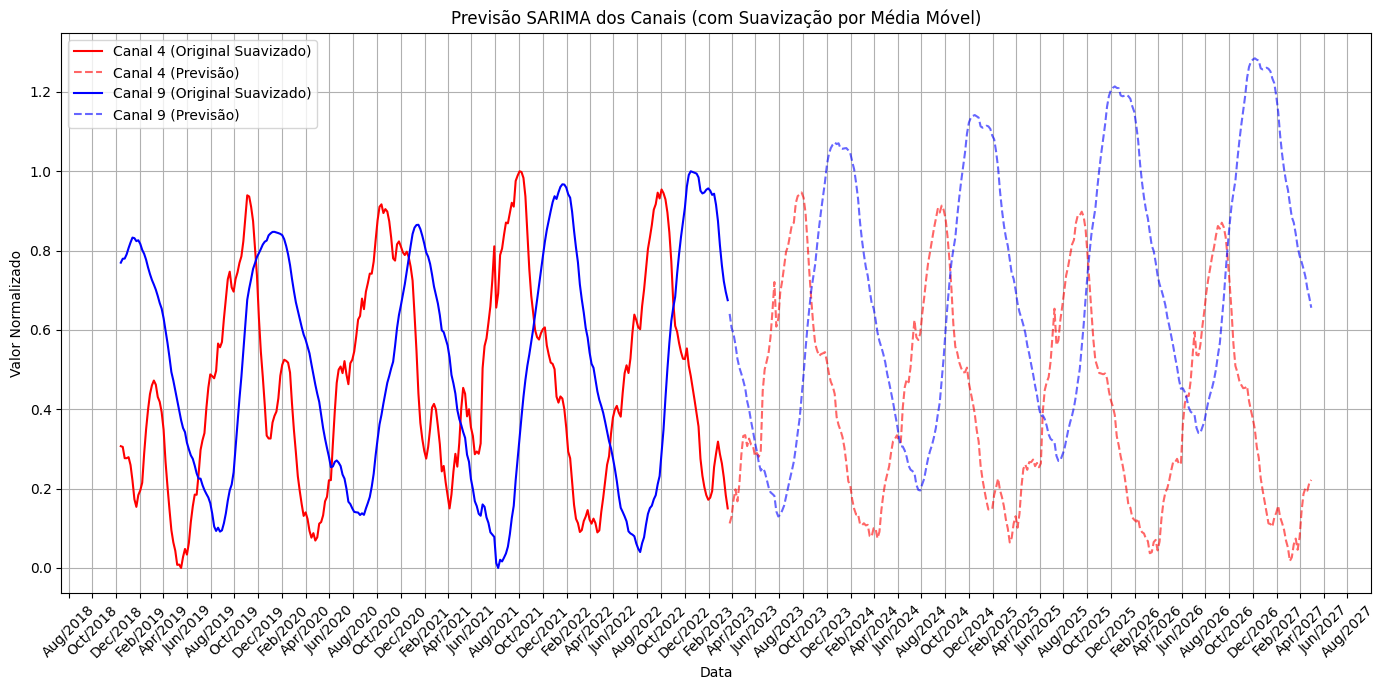

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

def moving_average(valores, window_size=7):
    if window_size <= 1:
        return valores
    padding = window_size // 2
    valores_padded = [valores[0]] * padding + valores + [valores[-1]] * padding
    suavizado = [
        sum(valores_padded[i:i+window_size]) / window_size
        for i in range(len(valores))
    ]
    return suavizado

def plot_sarima_forecast_duplo(dados, canais=(3, 8), sazonalidade=72, steps_a_frente=300):
    datas = sorted(dados.keys())
    datas_dt = [datetime.strptime(date, "%Y_%m_%d") for date in datas]

    intervalo = datas_dt[1] - datas_dt[0]
    datas_futuras = [datas_dt[-1] + (i + 1) * intervalo for i in range(steps_a_frente)]

    plt.figure(figsize=(14, 7))

    for canal_index, cor in zip(canais, ['red', 'blue']):
        serie = [dados[date][canal_index]["media"] for date in datas]

        # Suavizar com média móvel de 7 pontos
        serie_suave = moving_average(serie, window_size=7)

        # Normalizar
        minimo, maximo = min(serie_suave), max(serie_suave)
        serie_norm = [(v - minimo) / (maximo - minimo) for v in serie_suave]

        # Modelo SARIMA
        modelo = SARIMAX(
            serie_norm,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, sazonalidade),
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        resultado = modelo.fit(disp=False)
        previsao = resultado.forecast(steps=steps_a_frente)

        # Plotar original + previsão
        plt.plot(datas_dt, serie_norm, label=f"Canal {canal_index + 1} (Original Suavizado)", color=cor)
        plt.plot(datas_futuras, previsao, '--', label=f"Canal {canal_index + 1} (Previsão)", color=cor, alpha=0.6)

    plt.title("Previsão SARIMA dos Canais (com Suavização por Média Móvel)")
    plt.xlabel("Data")
    plt.ylabel("Valor Normalizado")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Chamada:
plot_sarima_forecast_duplo(dados, canais=(3, 8), sazonalidade=72, steps_a_frente=300)
